# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


<div class="span5 alert alert-success">
<p> Your answers to Q1 and Q2 here
    </p>
</div>

### 1. What test is appropriate for this problem?
The appropriate test for this problem would be a two sample z test for difference of proportions.


### Does CLT apply?

* Independence: Sample observations must be independent
     * Sample Size <10% of the population YES
 * Normal:
     * Number of successes and failures in each samples have to be at least 10 (SEE BELOW)
 * Random: 
     * Reviewing the experiement, the data appears to be random (YES)

In [5]:
# Resumes by race
w = data[data.race=='w']
b = data[data.race=='b']

# of resumes by race
n_b_res = data.groupby('race').size()[0]
n_w_res = data.groupby('race').size()[1]

# number of call backs per race
n_b_calls = sum(b.call)
n_w_calls = sum(w.call)

# proportions of callbacks
b_prop = n_b_calls / n_b_res
w_prop = n_w_calls / n_w_res

print(b_prop, w_prop)

0.06447638603696099 0.09650924024640657


In [6]:
print(n_b_calls, n_b_res, n_w_calls, n_w_res)

157.0 2435 235.0 2435


In [7]:
#Check that success and failures for both proportions are >10
b_success = b_prop * n_b_res
b_failures = (1-b_prop) * n_b_res
w_success = w_prop * n_w_res
w_failures = (1-w_prop) * n_w_res
print ( b_success, b_failures, w_success, w_failures)

157.0 2278.0 235.0 2200.0


In [8]:
# combined proportions for both white & black sounding name call backs
combined_prop = (n_b_calls + n_w_calls) / (n_b_res + n_w_res)
combined_prop

0.08049281314168377

### 2. What are the null and alternate hypotheses?


H0: The Proportion of callbacks from 'white name' resumes are **the same** as the proportions of callbacks from 'black name' resumes

H1: The proportions of callbacks from 'white name' resumes are **not** the same as proportions of callbacks from 'black name' resumes



### Does CLT apply?

* Independence: Sample observations must be independent
     * Sample Size <10% of the population YES
 * Normal:
     * Number of successes and failures in each samples have to be at least 10 (SEE BELOW)
 * Random: 
     * Reviewing the experiement, the data appears to be random (YES)

### 3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

#### Bootstrap approach

In [9]:
# generate two arrays of callback for both black & white soundings names
w = data[data.race=='w'].call
b = data[data.race=='b'].call


#### Create three functions

* **perm_sample** that will create a permutation sample from two datasets
* **diff_of_props** that finds the difference in proportions for two different datasets, this will be passed to the       **draw_perm_reps** function
* **draw_perm_reps** that generates permutation replicates

In [10]:
def draw_perm_reps(data1, data2, func, size = 1):
    """ Generate multiple permutation replicates."""
    # Initialize array of replicates
    perm_replicates = np.empty(size)
    
    # Generate permutation sample
    for i in range(size):
        perm_sample_1, perm_sample_2 = perm_sample(data1, data2)
        
        #computer the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
        
    return perm_replicates





In [11]:

def diff_of_props (data1, data2):
    """ Difference in proportions of 2 arrays"""
    #find the proprotions for both of the sample data
    prop1 = sum(data1) / len(data1)
    prop2 = sum(data2) / len(data2)
    #generate the test statistics of the difference in proportions
    diff = prop1 - prop2
    
    return diff

In [12]:
def perm_sample(data1, data2):
    """Generate a pemutation sample from two data sets"""
    #concatenate the datasets
    data = np.concatenate ((data1, data2))
    
    #permute the concatenated array
    permuted_data = np.random.permutation(data)
    
    #split the permuted array into two samples
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    
    return perm_sample_1, perm_sample_2

In [13]:
#difference in proportions from the original dataset
obs_diff_props = b_prop - w_prop
obs_diff_props

-0.032032854209445585

In [14]:
#generate 100,000 permutation replicates
perm_replicates = draw_perm_reps(b, w, diff_of_props, size = 100000)

In [15]:
#confidence interval
np.percentile(perm_replicates, [2.5, 97.5])


array([-0.01560575,  0.01560575])

In [16]:
np.sum(perm_replicates <= obs_diff_props)

1

In [17]:
#generate a p-value based on the replicates
p = np.sum(perm_replicates <= obs_diff_props) / len(perm_replicates)
p

1e-05

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


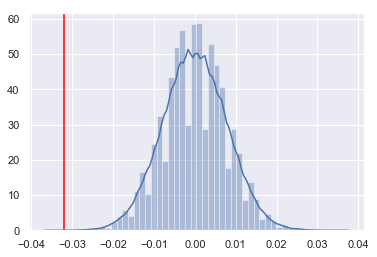

In [18]:
# a histogram of the permutation replicates, with the observed difference as a red vertical line 
sns.distplot(perm_replicates)
plt.axvline(x = obs_diff_props, color = 'red')
plt.xlabel = ('difference in proprotions')
plt.ylabel = ('PDF')
plt.show()

### Frequentist approach

In [19]:
#Find the Standard Error of the sampling distribution
ttl_resumes = n_w_res + n_b_res

SE = np.sqrt(2*combined_prop*(1-combined_prop) / ttl_resumes)
SE

0.005513236645169081

In [20]:
#Z Value = the difference in observerved proprotions, minus the proportion mean (0 due to our hypothesis of no difference) 
#divided by the SE

Z = (b_prop - w_prop) / SE

ME = np.absolute(Z * SE)
ME

0.032032854209445585

The Margine of error is .03

In [21]:
# Calculatore the Confidence Interval
ci_upper = (b_prop - w_prop) + ME
ci_lower = (b_prop - w_prop) - ME
print('CI Upper: ', ci_upper, 'CI Lower: ', ci_lower)


CI Upper:  0.0 CI Lower:  -0.06406570841889117


The z table is limited to -3.49, with a p value of .0002. Z < -3.49. See below for calculating the p value using scipy

In [22]:
stats.norm.cdf(Z)

3.120431080512834e-09

Given how small the p value is, we can reject H0 that there is no difference in call backs between black and white sounding names.

### 4. Write a story describing the statistical significance in the context or the original problem.

Given how  small the p value is, we can reject the H0 hypothesis that there is no difference in call backs between black and white sounding names. 

### 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

The analysis does not mean that race/name is the most important factor in callback success. Because I only looked at differences in this one variable. Further analysis would be needed to check for other variables, such as years of experience, number of jobs held, volunteer work etc. Many variables go into job selection, so we cannot say that this is the most imnportant factor. This is underscored by the fact that both call back rates were less than 10%. I would look at other correlations for callback success with the other variables that were captured. 